In [1]:
import awalipy

[Warning] The python module awalipy relies on compilation executed "on-the-fly" depending on the context (type of weights, of labels, etc.). As a result, the very first call to a given function in a given context may take up to 10 seconds. 


## System description
The problem is given by two components:
 1. dictionary `constraints`${}\colon \mathsf{Var} \to \mathsf{RE}$. We expect the regular expressions given as strings for now.
 2. equation $e$ of the form $e \in \mathsf{Var}^* \cdot \{=\} \cdot \mathsf{Var}^*$. This is specified by `e_l` and `e_r`, which can be lists of strings (var-names) or as a single string if variables are only characters.

In [2]:
def equation_str(e_l, e_r):
    return f"{e_l} = {e_r}"

In [3]:
e_l = "xyz"
e_r = "xyxy"

alph = "abc"
alph_exp = f"({'+'.join(alph)})"
sigma_plus = f"{alph_exp}{alph_exp}*"
constraints = {
    "x" : sigma_plus,
    "y" : f"{alph_exp}{sigma_plus}",
    "z" : sigma_plus
}

e_l = "xyz"
e_r = "xyxy"

In [4]:
print(equation_str(e_l, e_r))
print(constraints)

xyz = xyxy
{'x': '(a+b+c)(a+b+c)*', 'y': '(a+b+c)(a+b+c)(a+b+c)*', 'z': '(a+b+c)(a+b+c)*'}


## Conversion to automata and creating chains
The first step of the approach is to create automata for the variables. Then, we will create a chains of the automata corresponding to the sides of the equations, these will represent the languages of each sides.

In [5]:
def automata_for_side(var_sequence, re_dict, alphabet):
    """
    Create automata for sequence of variables.
    
    For a sequence of variables ``x1, … , xn`` and a dictionary
    that maps variables to regular expressions (REs) create a 
    sequence of automata ``a1, … , an`` that represent the 
    corresponding languages given by the REs. This is,
    ``ai`` represents the language of ``re_dict[xi]``.
    
    If one variable occurs multiple times in the sequence, the
    distinct automata are different objects.
    
    Parameters
    ----------
    var_sequence : str or list of str
        Define the sequence of variable names. 
        Str can be used only if variable names are characters.
    re_dict : dict [str → str]
        Maps variable names to regular expressions
    alphabet : str
        Alphabet of the regular expressions
    
    Returns
    -------
    automata : list of awali automata
        Automaton ``ai`` represents the language of ``re_dict[xi]``.
    """
    automata = []
    for var in var_sequence:
        re_str = re_dict[var]
        re = awalipy.RatExp(re_str, alphabet=alphabet)
        automata.append(re.exp_to_aut())
    return automata

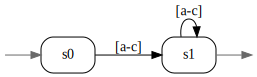

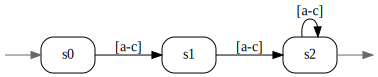

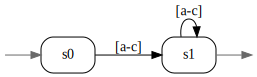

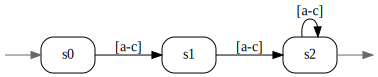

In [6]:
auts = automata_for_side(e_r, constraints, alph)
for aut in auts:
    aut.display()

In [7]:
def union_multi(automata):
    """
    Make union of multiple automata.
    
    Parameters
    ----------
    automata : list of auts
        Must be non-empty.
        All automata must use the same alphabet.
        
    Returns
    -------
    aut
        parallel union of auts in ``automata``
    """
    res = awalipy.make_automaton(automata[0].alphabet())
    for aut in automata:
        res.union_here(aut)

    return res

def chain_automata(automata):
    """
    Chain sequence of auts into aut for concatenation.
    
    Connect the automata in the sequence by ε-transitions. For
    ``a_1, a_2, … , a_n`` create automaton A that represents the
    language L(A) = L(a_1) · L(a_2) · … · L(a_n). A is basically
    an union of ``a_1 … a_n`` as they are, connected with
    ε-transitions. Each final state of ``a_i`` is connected by
    an ε-transition with each initial state of ``a_{i+1}
    
    Parameters
    ----------
    automata : list of auts
        Must be non-empty
    
    Returns
    -------
    A : aut 
        Automaton that links auts from ``automata`` by ε-transitions
        beteen final an inital states.
    """
    res = union_multi(automata)
    res.allow_eps_transition_here()
    
    # pre_a is the automaton which will be source of ε-transitions,
    # next_a is the automaton whose inital states receive the ε-tr.
    # offsets keep the shift in automata numbers between res and 
    #   pre/next
    pre_a = automata[0]
    pre_offset = 0
    
    # 1. For each final of pre_a:
    #     I. add ε to next_a
    #     II. Unset final
    # 2. Unset init_states of next_a
    for next_a in automata[1:]:
        next_offset = pre_offset + len(pre_a.states())
        
        for final_pre in pre_a.final_states():
            final_res = pre_offset + final_pre
            
            # Add ε-transitions
            for init_next in next_a.initial_states():
                init_res = next_offset + init_next
                res.add_eps_transition(final_res, init_res)              
            
            res.unset_final(final_res)
        
        for init_next in next_a.initial_states():
            init_res = next_offset + init_next
            res.unset_initial(init_res)
            
        pre_a = next_a
        pre_offset = next_offset
            
    return res

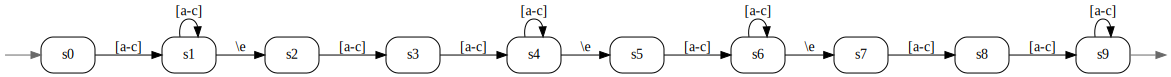

In [8]:
chain = chain_automata(auts)
chain.display()

## Make product and noodles
The chains of automata are the main input of the core algorithm for SAT. The core of the SAT algorithm is the function `noodlify` applied on a product of left and right automata. We need to make a special product operator, that keeps the ε-transitions on the left side, while it minimizes the other automaton.

In [9]:
automata_l = automata_for_side(e_l, constraints, alph)
automata_r = automata_for_side(e_r, constraints, alph)
chain_l = chain_automata(automata_l)
chain_r = chain_automata(automata_r)

In [37]:
chain_l.eps

[27]

In [81]:
def eps_preserving_product(aut_l, aut_r, opts={}):
    """
    Intersection of ε-NFA with NFA.
    
    Create product of ``aut_l`` and ``aut_r``, where ``aut_l``
    can contain ε-transitions. The product preserves the 
    ε-transitions of ``aut_l``. This means, for each ε-trans
    of the form `s -ε-> p` and each product state `(s, a)`, an
    ε-transition `(s, a) -ε-> (p, a)` is created. 
    
    Parameters
    ----------
    aut_l : aut with ε-transitions
    aut_r : aut without ε-transitions
    
    Automata must share alphabets.
    
    Returns
    -------
    aut
        Product of ``aut_l`` with ``aut_r`` with ε-transitions
        preserved.
        
    Notes
    -----
    Currently inefficient! It builds all pairs of states and
    only later trims the automaton. We should build only the
    reachable part to speed things up.
    """
    names = opts.get("history", False)
    
    state_map = {}
    alphabet = aut_l.alphabet()
    new_aut = awalipy.make_automaton(alphabet)
    new_aut.allow_eps_transition_here()
    
    # Create states
    for s in aut_l.states():
        for t in aut_r.states():
            if names:
                st = new_aut.add_state(f"{aut_l.get_state_name(s)} | {aut_r.get_state_name(t)}")
            else:
                st = new_aut.add_state()
            state_map[s,t] = st
            if aut_l.is_final(s) and aut_r.is_final(t):
                new_aut.set_final(st)
            if aut_l.is_initial(s) and aut_r.is_initial(t):
                new_aut.set_initial(st)
                
    for sl in aut_l.states():
        for sr in aut_r.states():
            for a in alphabet:
                for tl in aut_l.outgoing(sl,a):
                    dstl = aut_l.dst_of(tl)
                    for tr in aut_r.outgoing(sr,a):
                        dstr = aut_r.dst_of(tr)
                        new_aut.set_transition(state_map[sl,sr], state_map[dstl,dstr], a)
                        
            for tl in aut_l.outgoing(sl, "\e"):
                dstl = aut_l.dst_of(tl)
                new_aut.add_eps_transition(state_map[sl,sr], state_map[dstl,sr])
    new_aut.trim_here()
    
    return new_aut

In [82]:
def one_sided_product(chain_l, chain_r, opts={}):
    aut_r = chain_r.minimal_automaton()
    
    return eps_preserving_product(chain_l, aut_r, opts)

In [83]:
chain_r.get_state_name(2)

's2'

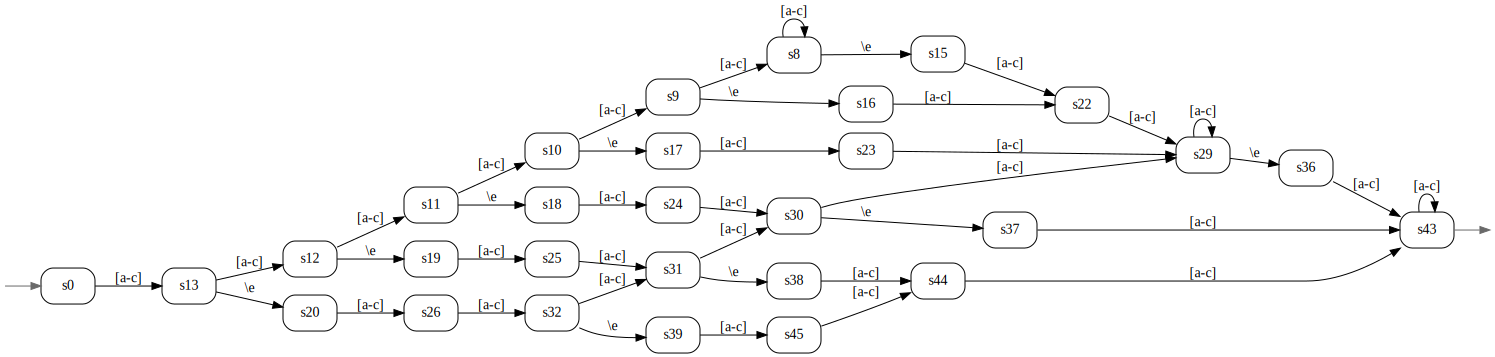

In [84]:
product = one_sided_product(chain_l, chain_r, {"history" : False})
product.display()

In [ ]:
chain_l.outgoing